In [31]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from PIL import Image
from pathlib import Path
import os
from keras.preprocessing.image import load_img, img_to_array
import os.path
from sklearn.utils import shuffle

from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import Callback, EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers.experimental import preprocessing

from sklearn.metrics import classification_report, confusion_matrix
import itertools


In [32]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, compare_historys, walk_through_dir, pred_and_plot

--2024-02-02 02:08:07--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.109.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: 'helper_functions.py.1'

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2024-02-02 02:08:07 (54.0 MB/s) - 'helper_functions.py.1' saved [10246/10246]



In [33]:
def process_dataset(dataset_path):
    
    image_dir = Path(dataset_path)
    filepaths = list(image_dir.glob('**/*.JPG')) + list(image_dir.glob('**/*.jpg')) + list(image_dir.glob('**/*.png'))
    labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))
    filepaths = pd.Series(filepaths, name='Filepath').astype(str)
    labels = pd.Series(labels, name='Label')
    dataset_df = pd.concat([filepaths, labels], axis=1)

    return dataset_df

def walk_through_dir(dataset_paths):
    all_datasets = pd.DataFrame(columns=['Filepath', 'Label'])

    for dataset_path in dataset_paths:
        print("-" * 90)
        print(f"Processing directory: {dataset_path}")
        dataset_df = process_dataset(dataset_path)
        all_datasets = pd.concat([all_datasets, dataset_df], ignore_index=True)

    return all_datasets

dataset_paths = [
    "../input/fire-dataset/fire_dataset",
    "../input/fire-and-smoke-dataset",
    "../input/forest-fire",
    "../input/test-dataset",
    "../input/house-rooms-streets-image-dataset"
]

final_dataset = walk_through_dir(dataset_paths)
print(final_dataset.info())

------------------------------------------------------------------------------------------
Processing directory: ../input/fire-dataset/fire_dataset
------------------------------------------------------------------------------------------
Processing directory: ../input/fire-and-smoke-dataset
------------------------------------------------------------------------------------------
Processing directory: ../input/forest-fire
------------------------------------------------------------------------------------------
Processing directory: ../input/test-dataset
------------------------------------------------------------------------------------------
Processing directory: ../input/house-rooms-streets-image-dataset
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44723 entries, 0 to 44722
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Filepath  44723 non-null  object
 1   Label     44723 non-null  object
dtypes: object(2)
memo

In [34]:
final_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44723 entries, 0 to 44722
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Filepath  44723 non-null  object
 1   Label     44723 non-null  object
dtypes: object(2)
memory usage: 698.9+ KB


In [35]:
unique_labels = final_dataset["Label"].unique()
print(unique_labels)

['non_fire_images' 'fire_images' 'smoke' 'fire' 'default' 'train_fire'
 'test_big' 'train-smoke' 'test_small' '0' '1' 'street_data' 'house_data']


In [36]:
label_mapping = {
    'non_fire_images': 0,
    'fire_images': 1,
    'smoke': 1,
    'fire': 1,
    'default': 0,
    'train_fire': 1,
    'test_big': 1,
    'train-smoke': 1,
    'test_small': 1,
    '0': 0,
    '1': 1,
    'street_data':0,
    'house_data': 0
}

final_dataset["Label"] = final_dataset["Label"].replace(label_mapping)


In [37]:
final_dataset

Filepath  Label
0      ../input/fire-dataset/fire_dataset/non_fire_im...      0
1      ../input/fire-dataset/fire_dataset/non_fire_im...      0
2      ../input/fire-dataset/fire_dataset/non_fire_im...      0
3      ../input/fire-dataset/fire_dataset/non_fire_im...      0
4      ../input/fire-dataset/fire_dataset/non_fire_im...      0
...                                                  ...    ...
44718  ../input/house-rooms-streets-image-dataset/kag...      0
44719  ../input/house-rooms-streets-image-dataset/kag...      0
44720  ../input/house-rooms-streets-image-dataset/kag...      0
44721  ../input/house-rooms-streets-image-dataset/kag...      0
44722  ../input/house-rooms-streets-image-dataset/kag...      0

[44723 rows x 2 columns]

In [38]:
final_dataset = shuffle(final_dataset.reset_index(drop=True), random_state=42)

In [39]:
final_dataset

Filepath  Label
39836  ../input/house-rooms-streets-image-dataset/kag...      0
43594  ../input/house-rooms-streets-image-dataset/kag...      0
21610  ../input/house-rooms-streets-image-dataset/kag...      0
14500        ../input/forest-fire/train-smoke/000323.jpg      1
6978         ../input/forest-fire/train-smoke/011671.jpg      1
...                                                  ...    ...
6265         ../input/forest-fire/train-smoke/006213.jpg      1
11284        ../input/forest-fire/train-smoke/007761.jpg      1
38158  ../input/house-rooms-streets-image-dataset/kag...      0
860    ../input/fire-dataset/fire_dataset/fire_images...      1
15795        ../input/forest-fire/train-smoke/005553.jpg      1

[44723 rows x 2 columns]

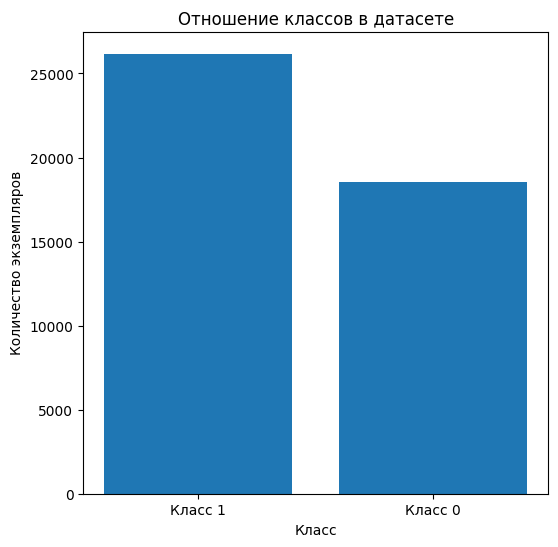

In [40]:
import matplotlib.pyplot as plt

class_counts = final_dataset['Label'].value_counts()

plt.figure(figsize=(6, 6))
plt.bar(class_counts.index, class_counts.values)
plt.xlabel('Класс')
plt.ylabel('Количество экземпляров')
plt.title('Отношение классов в датасете')
plt.xticks(class_counts.index, ['Класс 1', 'Класс 0'])
plt.show()


In [41]:
unique_labels_new = final_dataset["Label"].unique()
print(unique_labels_new)

[0 1]


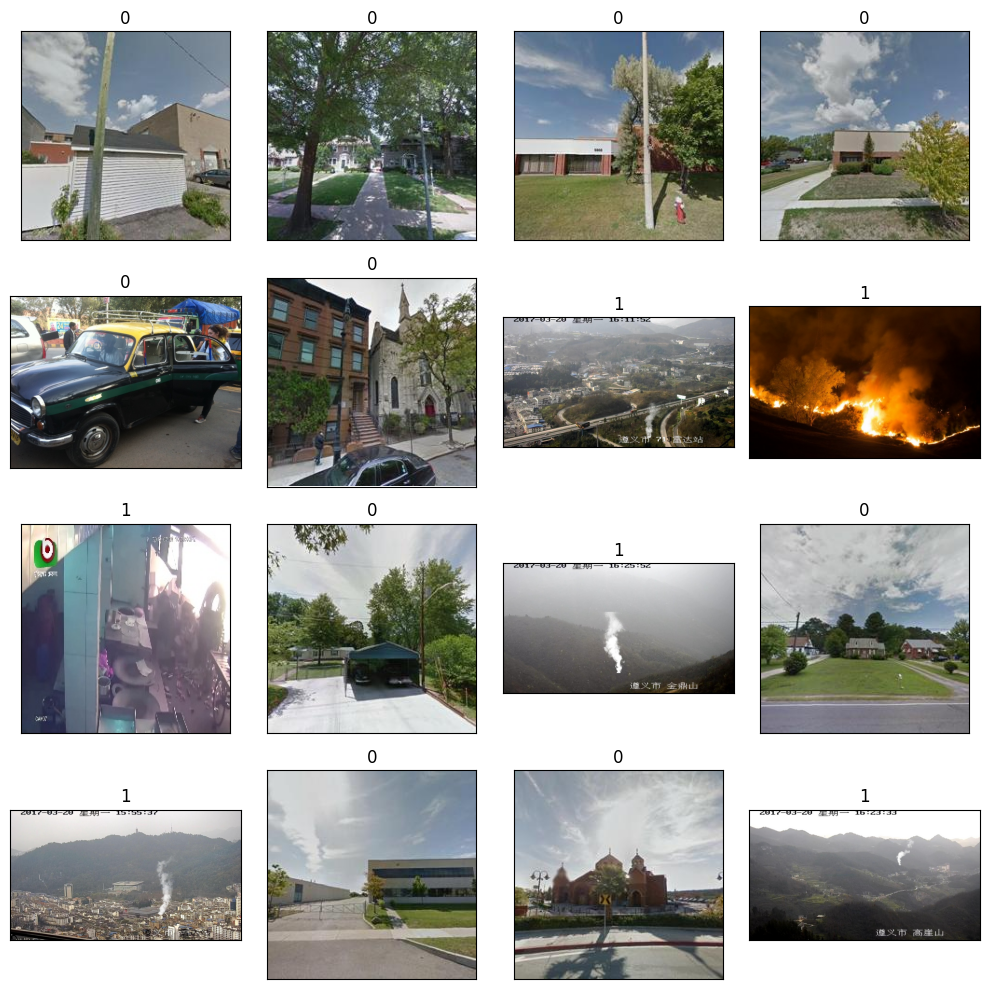

In [42]:
import matplotlib.image as mpimg
random_index = np.random.randint(0, len(final_dataset), 16)
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(10, 10),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    image = Image.open(final_dataset.Filepath[random_index[i]])
    ax.imshow(image)
    ax.set_title(final_dataset.Label[random_index[i]])
plt.tight_layout()
plt.show()

In [43]:
train_df, test_df = train_test_split(final_dataset, test_size=0.2, shuffle=True, random_state=42)

In [44]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_generator = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input,
    validation_split=0.2
)

test_generator = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
)

# Предобработка данных

In [45]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image

class CustomDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_path = self.dataframe.iloc[idx]['Filepath']
        label = self.dataframe.iloc[idx]['Label']
        img = Image.open(img_path).convert('RGB')
        if self.transform:
            img = self.transform(img)

        # Приведение к типу float, перемещение на CUDA, деление на 255
        img = transforms.ToTensor()(img)
        img = img.cuda()
        img /= 255.0

        return img, label

transformations = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
])

train_dataset = CustomDataset(train_df, transform=transformations)
test_dataset = CustomDataset(test_df, transform=transformations)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


In [46]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(224,224),
  layers.experimental.preprocessing.Rescaling(1./255),
])

# Запуск детектора на случайных изображениях

In [47]:
n = int(input("Введите число изображений для проверки детектора"))

Введите число изображений для проверки детектора 10


1/1 [==============================] - 1s 1s/step


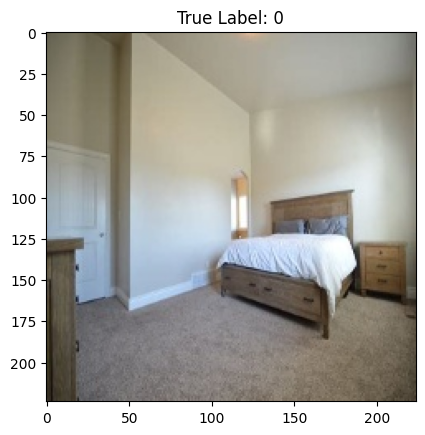

1/1 [==============================] - 0s 34ms/step


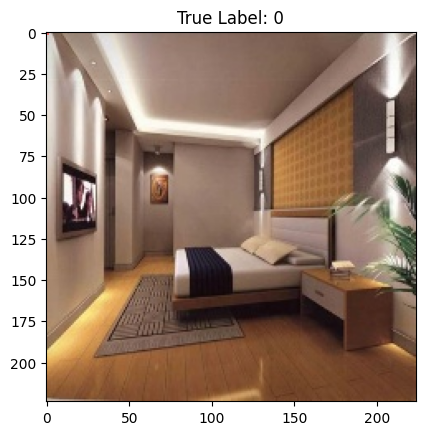

1/1 [==============================] - 0s 64ms/step


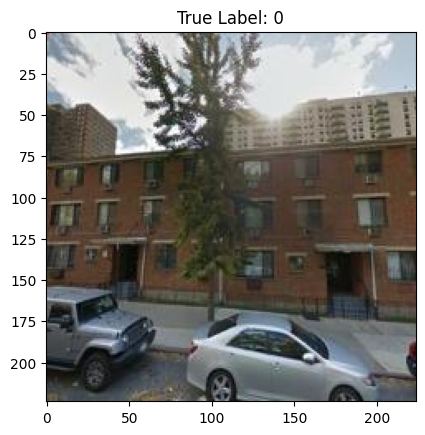

1/1 [==============================] - 0s 35ms/step


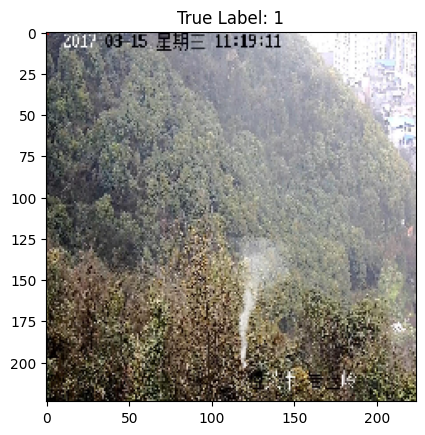

1/1 [==============================] - 0s 42ms/step


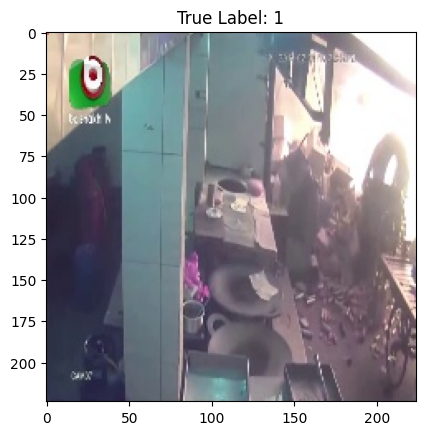

1/1 [==============================] - 0s 35ms/step


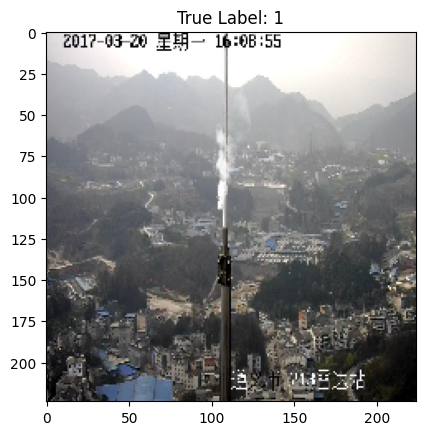

1/1 [==============================] - 0s 38ms/step


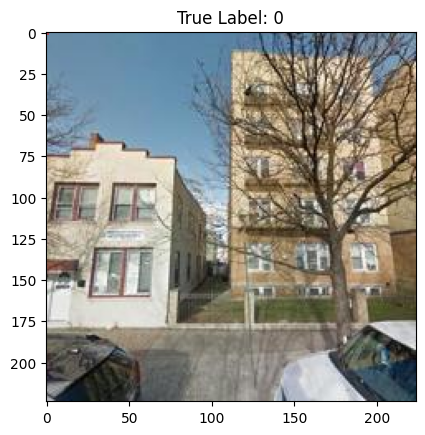

1/1 [==============================] - 0s 33ms/step


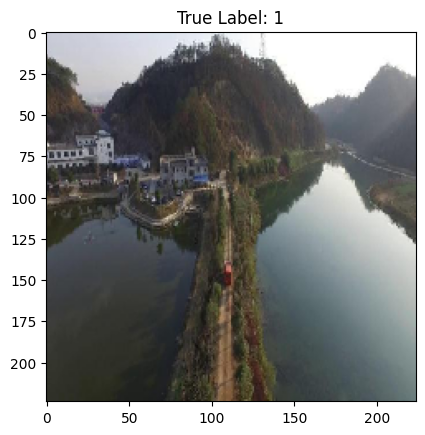

1/1 [==============================] - 0s 47ms/step


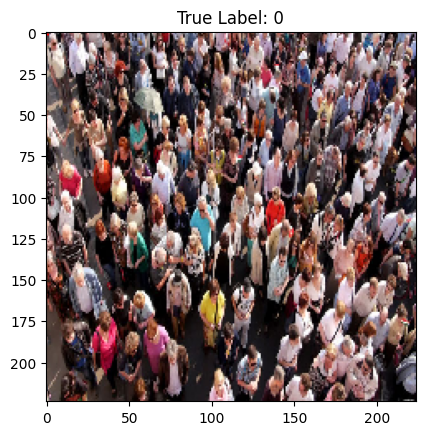

1/1 [==============================] - 0s 38ms/step


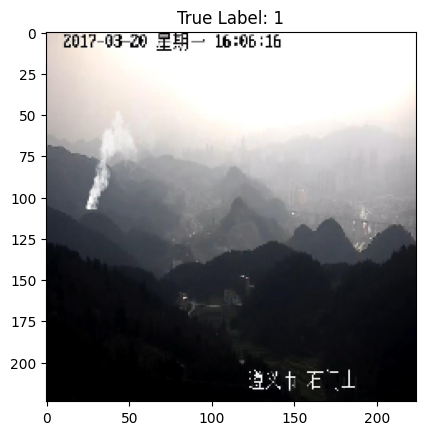

In [48]:
import tensorflow as tf
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches

pretrained_model = tf.keras.applications.MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)

pretrained_model.trainable = False

def predict_image(model, img_path):
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)

    predictions = model.predict(img_array)
    return predictions[0]

def plot_image_with_box(img_path, true_label, predictions):
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    fig, ax = plt.subplots(1)
    ax.imshow(img_array / 255.0)

    # баундинг бокс
    rect = patches.Rectangle((predictions[0], predictions[1]),
                             predictions[2] - predictions[0],
                             predictions[3] - predictions[1],
                             linewidth=2, edgecolor='r', facecolor='none')
    ax.add_patch(rect)

    plt.title(f"True Label: {true_label}")
    plt.show()

for _, row in train_df.sample(n).iterrows():  
    img_path = row['Filepath']
    true_label = row['Label']

    predictions = predict_image(pretrained_model, img_path)
    plot_image_with_box(img_path, true_label, predictions)


In [49]:
checkpoint_path = "fires_classification_model_checkpoint"
checkpoint_callback = ModelCheckpoint(checkpoint_path,
                                      save_weights_only=True,
                                      monitor="val_accuracy",
                                      save_best_only=True)

In [50]:
early_stopping = EarlyStopping(monitor = "val_loss", 
                               patience = 5,
                               restore_best_weights = True) 

# Измерение качества работы модели

In [51]:
import tensorflow as tf

def accuracy(y_true, y_pred):
    
    correct_predictions = tf.reduce_sum(tf.cast(tf.equal(y_true, tf.round(y_pred)), tf.float32))
    total_samples = tf.cast(tf.size(y_true), tf.float32)
    accuracy_value = correct_predictions / total_samples * 100
    return accuracy_value

def precision(y_true, y_pred, positive_class=1):

    true_positive = np.sum((np.array(y_true) == positive_class) & (np.array(y_pred) == positive_class))
    predicted_positive = np.sum(np.array(y_pred) == positive_class)
    
    precision_value = true_positive / predicted_positive if predicted_positive != 0 else 0
    return precision_value

def recall(y_true, y_pred, positive_class=1):

    true_positive = np.sum((np.array(y_true) == positive_class) & (np.array(y_pred) == positive_class))
    actual_positive = np.sum(np.array(y_true) == positive_class)

    recall_value = true_positive / actual_positive if actual_positive != 0 else 0
    return recall_value

def f1_score(y_true, y_pred, positive_class=1):

    precision_value = precision(y_true, y_pred, positive_class)
    recall_value = recall(y_true, y_pred, positive_class)

    f1_score_value = 2 * (precision_value * recall_value) / (precision_value + recall_value) if (precision_value + recall_value) != 0 else 0
    return f1_score_value

# Обучение модели-детектора

In [53]:
from keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping

inputs = pretrained_model.input
x = resize_and_rescale(inputs)
x = Dense(256, activation='relu')(pretrained_model.output)
x = Dropout(0.2)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.2)(x)

outputs = Dense(1, activation='sigmoid')(x)

model = Model(inputs=inputs, outputs=outputs)

model.compile(
    optimizer=Adam(0.0001),
    loss='binary_crossentropy',
    metrics=[accuracy]
)

early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1, restore_best_weights=True)

history = model.fit(
    train_images,
    steps_per_epoch=len(train_images),
    validation_data=val_images,
    validation_steps=len(val_images),
    epochs=10,
    callbacks=[
        early_stopping,
        create_tensorboard_callback("training_logs", "fire_classification"),
        checkpoint_callback,
    ]
)

if early_stopping.stopped_epoch > 0:
    print("Training finished early due to early stopping.")
else:
    print("Training completed all epochs.")


Saving TensorBoard log files to: training_logs/fire_classification/20240202-025002
Epoch 1/100
895/895 [==============================] - 208s 228ms/step - loss: 0.0502 - accuracy: 98.3764 - val_loss: 0.0219 - val_accuracy: 99.2188
Epoch 2/100
895/895 [==============================] - 202s 226ms/step - loss: 0.0180 - accuracy: 99.3401 - val_loss: 0.0175 - val_accuracy: 99.4141
Epoch 3/100
895/895 [==============================] - 206s 230ms/step - loss: 0.0118 - accuracy: 99.6473 - val_loss: 0.0151 - val_accuracy: 99.4978
Epoch 4/100
895/895 [==============================] - 200s 223ms/step - loss: 0.0075 - accuracy: 99.7800 - val_loss: 0.0148 - val_accuracy: 99.5815
Epoch 5/100
895/895 [==============================] - 205s 229ms/step - loss: 0.0049 - accuracy: 99.8568 - val_loss: 0.0167 - val_accuracy: 99.5675
Epoch 6/100
895/895 [==============================] - 203s 227ms/step - loss: 0.0038 - accuracy: 99.8918 - val_loss: 0.0181 - val_accuracy: 99.5580
Epoch 7/100
895/895 [==

In [55]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix

test_predictions = model.predict(test_images)
test_labels = test_df['Label'].values  

binary_predictions = np.round(test_predictions).flatten()

print("Classification Report:")
print(classification_report(test_labels, binary_predictions))

print("\nConfusion Matrix:")
print(confusion_matrix(test_labels, binary_predictions))

accuracy_value = accuracy(test_labels, binary_predictions)
precision_value = precision(test_labels, binary_predictions)
recall_value = recall(test_labels, binary_predictions)
f1_score_value = f1_score(test_labels, binary_predictions)

print("\nMetrics:")
print(f"Accuracy: {accuracy_value:.2f}%")
print(f"Precision: {precision_value:.2f}")
print(f"Recall: {recall_value:.2f}")
print(f"F1-Score: {f1_score_value:.2f}")


280/280 [==============================] - 134s 477ms/step
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.99      1.00      5208
           1       0.99      0.99      0.99      3737

    accuracy                           0.99      8945
   macro avg       0.99      0.99      0.99      8945
weighted avg       0.99      0.99      0.99      8945


Confusion Matrix:
[[5178   30]
 [  22 3715]]

Metrics:
Accuracy: 99.42%
Precision: 0.99
Recall: 0.99
F1-Score: 0.99


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


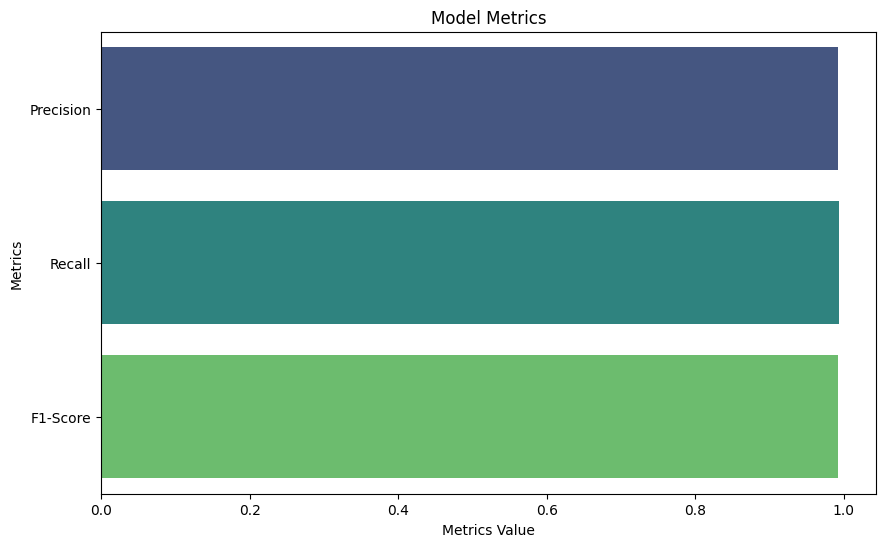

In [56]:
metrics_names = ['Precision', 'Recall', 'F1-Score']
metrics_values = [precision_value, recall_value, f1_score_value]

plt.figure(figsize=(10, 6))
sns.barplot(x=metrics_values, y=metrics_names, palette="viridis")
plt.title("Model Metrics")
plt.xlabel("Metrics Value")
plt.ylabel("Metrics")
plt.show()

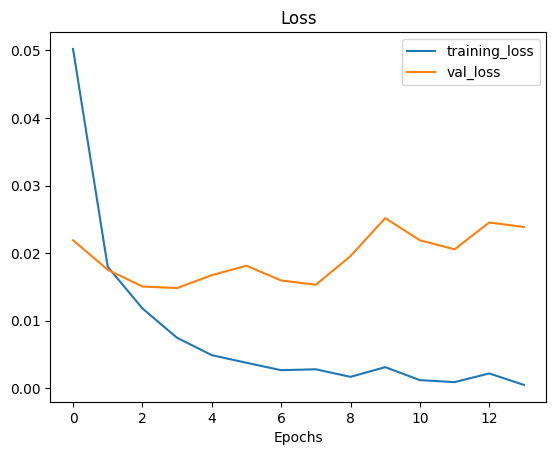

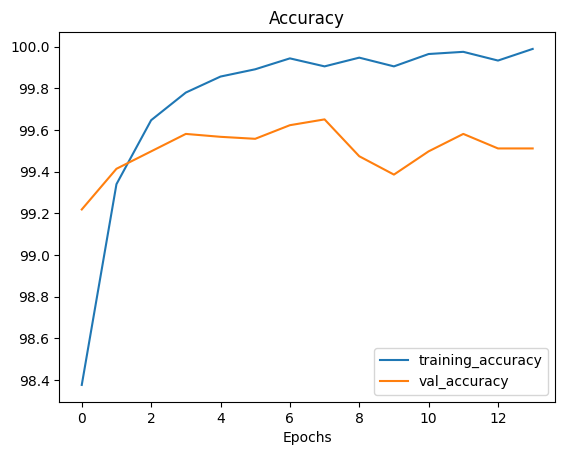

In [57]:
plot_loss_curves(history)

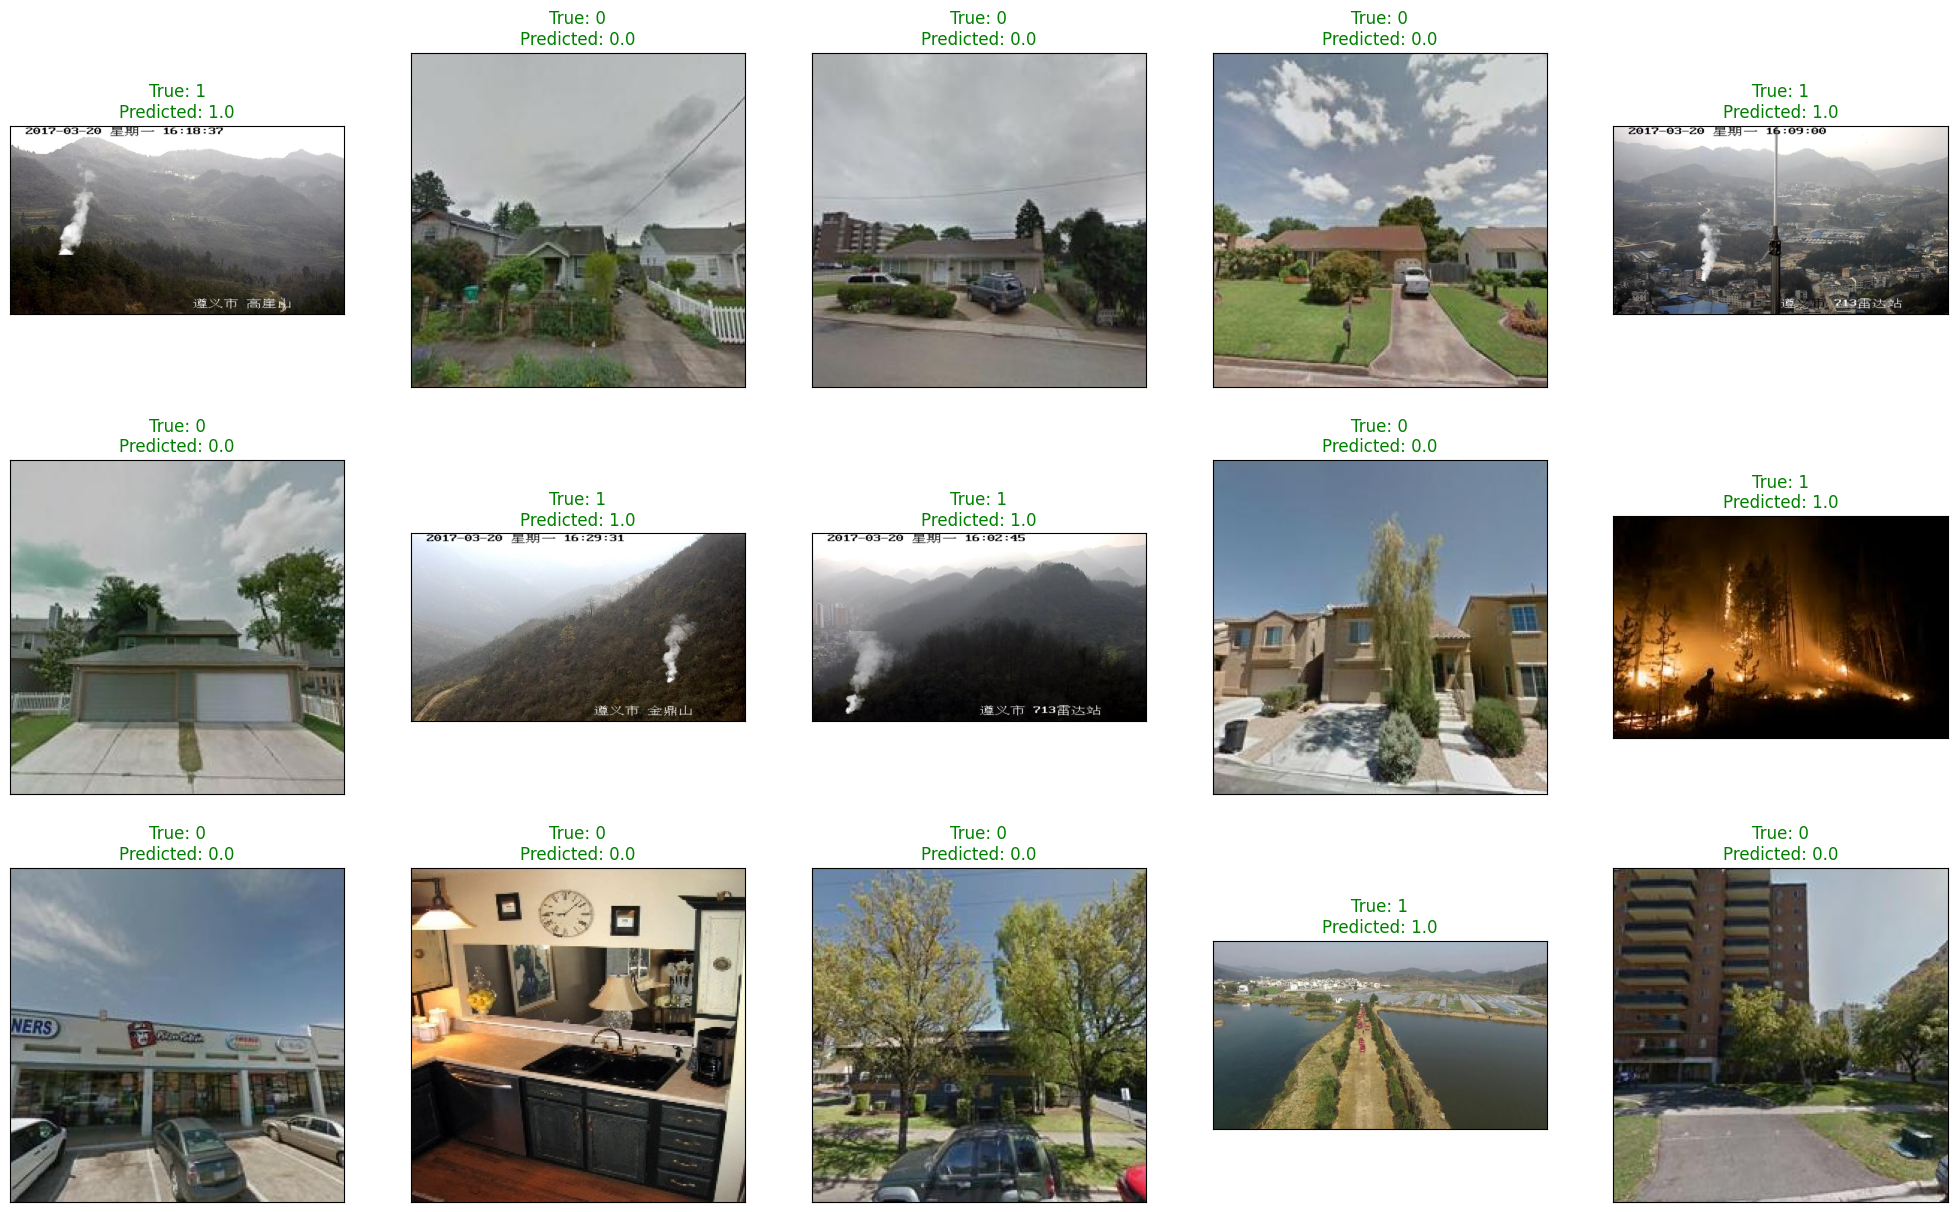

<Figure size 640x480 with 0 Axes>

In [58]:
random_index = np.random.randint(0, len(test_df) - 1, 15)
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(25, 15),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    image = Image.open(test_df.Filepath.iloc[random_index[i]])
    ax.imshow(image)
    
    if test_labels[random_index[i]] == binary_predictions[random_index[i]]:
        color = "green"
    else:
        color = "red"
    
    ax.set_title(f"True: {test_labels[random_index[i]]}\nPredicted: {binary_predictions[random_index[i]]}", color=color)

plt.show()
plt.tight_layout()


In [61]:
model.save_weights('my_model_weights1.h5')

#  Поиск путей применения этой модели в бизнесе/реальных задачах/набросок встраивания в веб/мобильное демо

Системы безопасности и мониторинга: Модель может быть интегрирована в системы видеонаблюдения для автоматического обнаружения пожаров в реальном времени. Это может быть полезно для обеспечения безопасности в крупных объектах, таких как торговые центры, склады, производственные предприятия и т.д.

Создание онлайн-платформы для мониторинга пожаров:

Пользователи могут зарегистрировать свои камеры на сайте.
Предоставление возможности просматривать изображения с камер в режиме реального времени через веб-интерфейс.
Использование модели для автоматического обнаружения пожаров на изображениях с камер.
Пользователи получают уведомления в случае обнаружения пожара, с предоставлением снимков и информации о местоположении.
Интеграция карты для визуализации местоположения камер и обнаруженных пожаров.
Возможность пользовательской обратной связи, такой как комментарии или подтверждение обнаруженных пожаров.

Автоматическое оповещение и реагирование: Модель может использоваться для автоматического оповещения служб пожаротушения или других служб чрезвычайной помощи при обнаружении пожара. Это позволяет сократить время реакции и уменьшить возможные убытки.

Мониторинг лесных пожаров: В области экологии и лесного хозяйства модель может использоваться для наблюдения и раннего обнаружения лесных пожаров. Это позволяет своевременно предпринимать меры по их тушению и предотвращению распространения.



Управление инфраструктурой: В городской инфраструктуре модель может быть применена для мониторинга и управления безопасностью в общественных местах, таких как станции метро, аэропорты и т.д.



Научные исследования: Модель может быть полезна для научных исследований в области пожаров. Это может включать в себя анализ статистики пожаров, выявление областей с повышенным риском, исследование поведения пожаров и т.д.